In [73]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)
pd.set_option('display.max_colwidth', None)

In [74]:
df = pd.read_csv("güneş_enerji_verileri/gunesenerji_uretim.csv")
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df = df[["date", "gunes"]].drop_duplicates()
df["gunes"] = df["gunes"].fillna(method="ffill")

df = df.rename(columns={"date": "ds", "gunes": "y"})

In [75]:
train_df = df[(df["ds"] >= "2022-01-01") & (df["ds"] <= "2024-12-31")]
test_df = df[(df["ds"] >= "2025-01-01")]

model = Prophet()
model.fit(train_df)

09:27:46 - cmdstanpy - INFO - Chain [1] start processing
09:27:54 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
test_df.shape

(2184, 2)

In [76]:
future = model.make_future_dataframe(periods=91*24, freq='H')
forecast = model.predict(future)
forecast.loc[forecast['yhat'] < 0, 'yhat'] = 0

In [77]:
common_index = test_df["ds"].isin(forecast["ds"])
actual_2025 = test_df[common_index].set_index("ds")
predicted_2025 = forecast.set_index("ds").loc[actual_2025.index]

mae = mean_absolute_error(actual_2025["y"], predicted_2025["yhat"])
r2 = r2_score(actual_2025["y"], predicted_2025["yhat"])

print(f"MAE: {mae:.2f}, R² Skoru: {r2:.4f}")


MAE: 131.68, R² Skoru: 0.8029


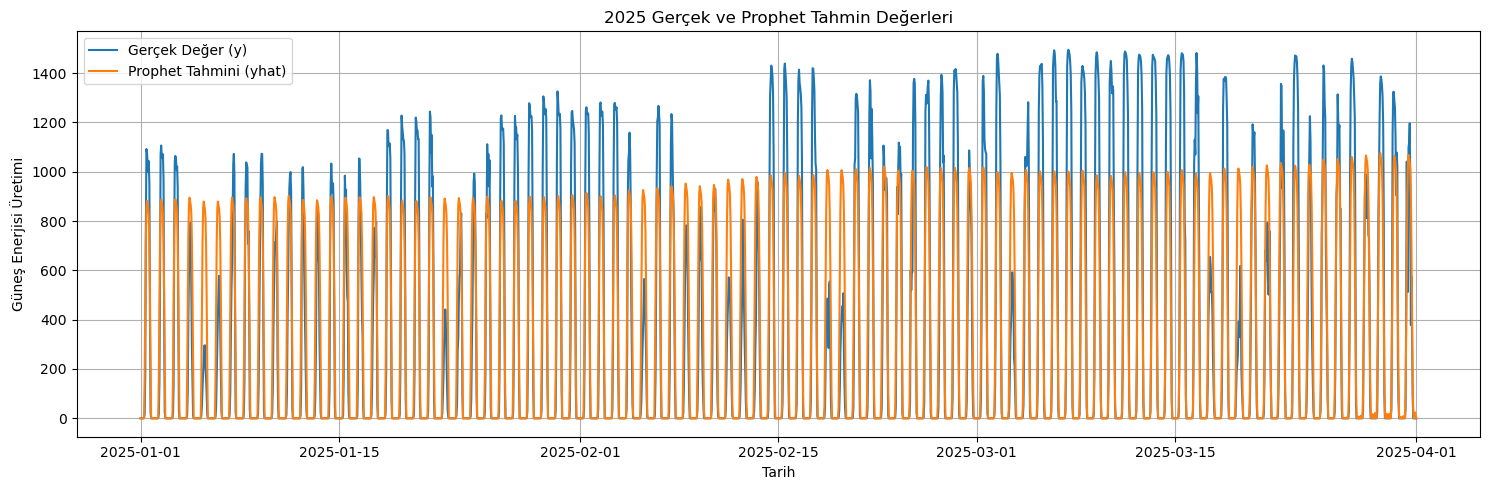

In [79]:
actual_2025 = actual_2025.sort_index()
predicted_2025 = predicted_2025.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(actual_2025.index, actual_2025["y"], label="Gerçek Değer (y)")
plt.plot(predicted_2025.index, predicted_2025["yhat"], label="Prophet Tahmini (yhat)")
plt.title("2025 Gerçek ve Prophet Tahmin Değerleri")
plt.xlabel("Tarih")
plt.ylabel("Güneş Enerjisi Üretimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Hava Durumu ile Prophet

In [80]:
df = pd.read_csv("güneş_enerji_verileri/gunesenerji_uretim.csv")
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df = df[["date", "gunes"]].drop_duplicates()
df["gunes"] = df["gunes"].fillna(method="ffill")

df = df.rename(columns={"date": "ds", "gunes": "y"})

In [81]:
weather=pd.read_csv("güneş_enerji_verileri/weather.csv")
df_kuruluguc=pd.read_csv("güneş_enerji_verileri/epias_kuruluguc.csv")

In [82]:
df_kuruluguc["entryDate"] = pd.to_datetime(df_kuruluguc["entryDate"])
df_kuruluguc["entryDate"]=df_kuruluguc["entryDate"].dt.date
expanded_rows = []
for _, row in df_kuruluguc.iterrows():
    date_range = pd.date_range(start="2022-01-01", end="2025-03-02", freq="D")
    for date in date_range:
        new_row = row.copy()
        new_row["entryDate"] = date
        expanded_rows.append(new_row)

df_kuruluguc_expanded = pd.DataFrame(expanded_rows)

In [83]:
df_kuruluguc_expanded=df_kuruluguc_expanded[(df_kuruluguc_expanded["entryDate"] >= pd.to_datetime("2022-01-01")) & (df_kuruluguc_expanded["entryDate"] <= pd.to_datetime("2025-03-01"))]
df_kuruluguc_expanded["entryDate"]=df_kuruluguc_expanded["entryDate"].dt.date
df_kuruluguc_expanded2 = df_kuruluguc_expanded.groupby(["entryDate", "city"], as_index=False)["installedPower"].sum()

In [84]:
weather['date'] = pd.to_datetime(weather['date'])
weather['Year'] = weather['date'].dt.year
weather['Month'] = weather['date'].dt.month
weather['Day'] = weather['date'].dt.day

df_kuruluguc_expanded2['entryDate'] = pd.to_datetime(df_kuruluguc_expanded2['entryDate'])
df_kuruluguc_expanded2['Year'] = df_kuruluguc_expanded2['entryDate'].dt.year
df_kuruluguc_expanded2['Month'] = df_kuruluguc_expanded2['entryDate'].dt.month
df_kuruluguc_expanded2['Day'] = df_kuruluguc_expanded2['entryDate'].dt.day

weather = weather.merge(df_kuruluguc_expanded2[['Year', 'Month', 'Day', 'installedPower', 'city']], left_on=['Year', 'Month', 'Day','city'], right_on=['Year', 'Month', 'Day','city'], how='left').drop(columns=['Day',"Year","Month","latitude","longitude"])
weather=weather[weather["installedPower"].notnull()]

In [85]:
weather["panel_temprature"]=weather["temperature_2m"]+(25*weather["global_tilted_irradiance_instant"]/800)
#Tp = To + (NOTC-20C)* It / 800 (NOCT (Nominal Operating Cell Temperature) --> panelin kendi sıcaklığını hesaplayan formül)

weather["productivity_per"]=weather["panel_temprature"].apply(lambda x: 1-((x-25)*0.004) if x>=25 else 1)
# 25 derecenin üzerinde her bir derece için güneş panellerinin verimliliği %0.04 düşer.
weather["productivity"]=weather["installedPower"]*weather["productivity_per"]

weather["non_cloud"] = 100 - weather["cloud_cover"]
weather["weather_relation"] = weather["productivity"]*weather["non_cloud"]*weather["sunshine_duration"]*weather["is_day"]/weather["productivity"].sum()/3600
# weather_relation değişkeni hava durumu verisinden yararlanarak oluşturulan değişkendir.

In [86]:
il_sum = weather.groupby('date')['weather_relation'].sum().reset_index()
il_sum["date"]=pd.to_datetime(il_sum['date']).dt.tz_localize(None)
df = pd.merge(df, il_sum, left_on='ds', right_on="date", how='left').drop(columns=["date"])
df['gunes_1g'] = df['y'].shift(24)
df.dropna(inplace=True)

In [87]:
train_df = df[(df["ds"] >= "2022-01-01") & (df["ds"] <= "2024-12-31")]
test_df = df[(df["ds"] >= "2025-01-01")]

model = Prophet()
model.add_regressor("weather_relation")
model.add_regressor("gunes_1g")
model.fit(df)

09:30:17 - cmdstanpy - INFO - Chain [1] start processing
09:30:24 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
forecast = model.predict(test_df)
forecast.loc[forecast['yhat'] < 0, 'yhat'] = 0

In [89]:
common_index = test_df["ds"].isin(forecast["ds"])
actual_2025 = test_df[common_index].set_index("ds")
predicted_2025 = forecast.set_index("ds").loc[actual_2025.index]

mae = mean_absolute_error(actual_2025["y"], predicted_2025["yhat"])
r2 = r2_score(actual_2025["y"], predicted_2025["yhat"])

print(f"MAE: {mae:.2f}, R² Skoru: {r2:.4f}")

MAE: 80.57, R² Skoru: 0.8739


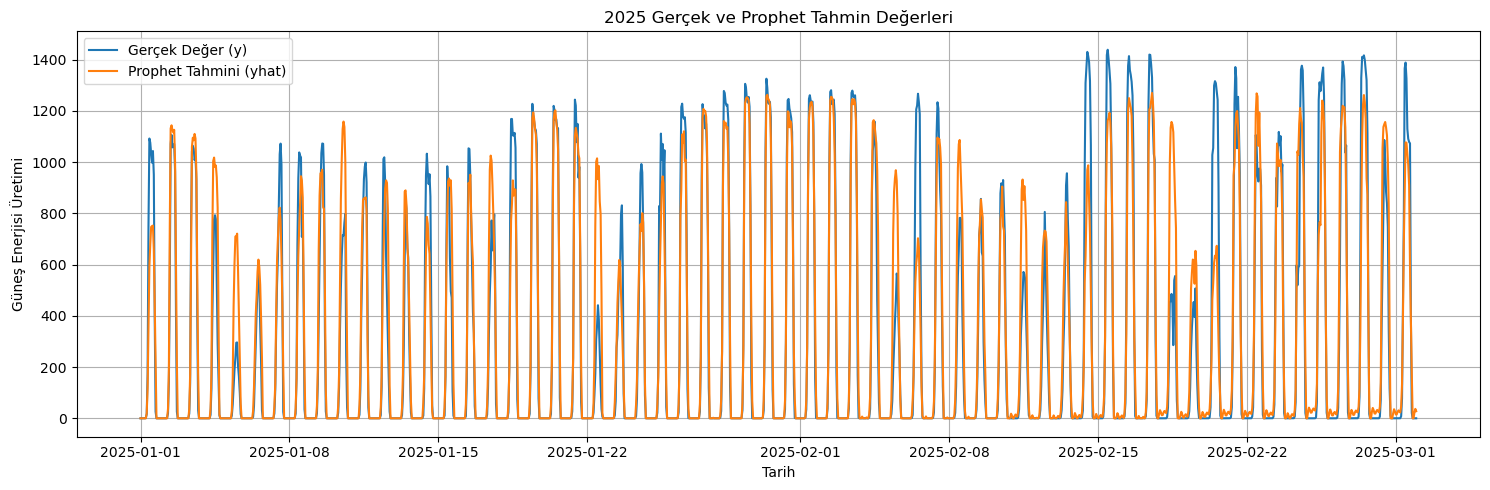

In [90]:
actual_2025 = actual_2025.sort_index()
predicted_2025 = predicted_2025.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(actual_2025.index, actual_2025["y"], label="Gerçek Değer (y)")
plt.plot(predicted_2025.index, predicted_2025["yhat"], label="Prophet Tahmini (yhat)")
plt.title("2025 Gerçek ve Prophet Tahmin Değerleri")
plt.xlabel("Tarih")
plt.ylabel("Güneş Enerjisi Üretimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()